### Importing Libraries

In [73]:
import pandas as pd
import numpy as np
import pickle
from gpt_few_shot_clf import MultiLabelFewShotGPTClassifier
from sklearn.model_selection import train_test_split
import ast
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import operator
from collections import Counter

### Importing CSV file with all incidents extracted from 250 LERs

In [5]:
df_test = pd.read_csv("./All_Incidents.csv")
df_test = df_test.replace(np.nan, '')
df_test

,Power plant,File Name,Cause of the event
0,South Texas,4981999007,This event was caused by degradation of the ma...
1,South Texas,4982000001,The cause of this event was:\n• Ineffective pr...
2,South Texas,4982000002,\nThe root cause for this event was a failure ...
3,South Texas,4982000003,The root cause for this event is workers' lack...
4,South Texas,4982000004,The root cause for this event was that special...
...,...,...,...
245,Davis-Besse,3462016008,The direct cause for the failure to properly a...
246,Davis-Besse,3462016009,\nThe direct cause of the generator lockout an...
247,Davis-Besse,3462017001,\nThe primary cause of the inadequate missile ...
248,Davis-Besse,3462017002,The direct cause of the damaged AFW Pump Turbi...


In [7]:
X = [sentence for sentence in df_test["Cause of the event"].tolist()]
len(X)

250

### Loading the saved model

In [8]:
with open('clf_fewshot.pkl', 'rb') as model_file:
    clf_fewshot = pickle.load(model_file)

### Predicting on all LERs

In [97]:
predictions_fewshot = clf_fewshot.predict(X)

100%|█████████████████████████████████████████| 250/250 [15:55<00:00,  3.82s/it]


### Saving results as DataFrame and CSV file

In [98]:
i = 0
columnNamesForResult = ["Power Plant", "Incident", "Predicted Labels"]

powerplants = []
incidents = []
predictedLabels = []

for row in range(len(df_test)):
    pred_labels = sorted(predictions_fewshot[i])
    predictedLabels.append(pred_labels)
    
    powerplant = df_test.iloc[row]['Power plant']
    powerplants.append(powerplant)
    
    paragraph = df_test.iloc[row]['Cause of the event']
    incidents.append(paragraph)
    
    i+=1
    
resultingDF = pd.DataFrame(columns=columnNamesForResult, data=
                           {"Power Plant": powerplants,
                            "Incident": incidents,
                            "Predicted Labels": predictedLabels})

In [99]:
resultingDF

,Power Plant,Incident,Predicted Labels
0,South Texas,This event was caused by degradation of the ma...,"[problem identification and resolution, work p..."
1,South Texas,The cause of this event was:\n• Ineffective pr...,"[leadership safety values and actions, problem..."
2,South Texas,\nThe root cause for this event was a failure ...,"[decision making, leadership safety values and..."
3,South Texas,The root cause for this event is workers' lack...,"[continuous learning, problem identification a..."
4,South Texas,The root cause for this event was that special...,"[decision making, problem identification and r..."
...,...,...,...
245,Davis-Besse,The direct cause for the failure to properly a...,"[leadership safety values and actions, persona..."
246,Davis-Besse,\nThe direct cause of the generator lockout an...,"[leadership safety values and actions, problem..."
247,Davis-Besse,\nThe primary cause of the inadequate missile ...,"[leadership safety values and actions, problem..."
248,Davis-Besse,The direct cause of the damaged AFW Pump Turbi...,"[continuous learning, problem identification a..."


In [100]:
drop_rows = []
for row in range(len(resultingDF)):
    if len(resultingDF.iloc[row]['Predicted Labels'][0]) == 1:
        print(resultingDF.iloc[row]['Incident'],'\n')
        drop_rows.append(row)
drop_rows

[]

In [101]:
resultingDF
resultingDF.to_csv("All_LERS.csv", index=False)

### Creating the Histogram Visualization

In [102]:
df_hist = pd.read_csv("All_LERS.csv")
df_hist

,Power Plant,Incident,Predicted Labels
0,South Texas,This event was caused by degradation of the ma...,"['problem identification and resolution', 'wor..."
1,South Texas,The cause of this event was:\n• Ineffective pr...,"['leadership safety values and actions', 'prob..."
2,South Texas,\nThe root cause for this event was a failure ...,"['decision making', 'leadership safety values ..."
3,South Texas,The root cause for this event is workers' lack...,"['continuous learning', 'problem identificatio..."
4,South Texas,The root cause for this event was that special...,"['decision making', 'problem identification an..."
...,...,...,...
245,Davis-Besse,The direct cause for the failure to properly a...,"['leadership safety values and actions', 'pers..."
246,Davis-Besse,\nThe direct cause of the generator lockout an...,"['leadership safety values and actions', 'prob..."
247,Davis-Besse,\nThe primary cause of the inadequate missile ...,"['leadership safety values and actions', 'prob..."
248,Davis-Besse,The direct cause of the damaged AFW Pump Turbi...,"['continuous learning', 'problem identificatio..."


In [103]:
# Flatten the data and count occurrences of each safety trait
traits_list = [ast.literal_eval(x) for x in df_hist["Predicted Labels"]]
all_traits = [trait for sublist in traits_list for trait in sublist]
trait_counts = Counter(all_traits)

In [104]:
#COUNTS OF OCCURRENCES
df_Counts = pd.DataFrame()
plants = ['Davis-Besse','South Texas','Diablo Canyon']
df_Counts['Power Plant'] = plants
df_Counts.set_index('Power Plant',inplace=True)

for plant in plants:
    plant_df = df_hist[df_hist['Power Plant'] == plant]
    traits_list = [ast.literal_eval(x) for x in plant_df["Predicted Labels"]]
    all_traits = [trait for sublist in traits_list for trait in sublist]
    item_counts = Counter(all_traits)
    for trait, count in item_counts.items():
        df_Counts.at[plant,trait] = int(count)
df_Counts

,continuous learning,problem identification and resolution,questioning attitude,work processes,decision making,effective safety communication,personal accountability,leadership safety values and actions,environment for raising concerns
Power Plant,,,,,,,,,
Davis-Besse,22.0,71.0,29.0,76.0,14.0,8.0,13.0,10.0,NaN
South Texas,17.0,83.0,14.0,83.0,17.0,7.0,12.0,15.0,2.0
Diablo Canyon,10.0,54.0,13.0,54.0,9.0,4.0,16.0,6.0,NaN


In [105]:
plant_counts = df_hist['Power Plant'].value_counts()
plant_counts

Power Plant
South Texas      104
Davis-Besse       80
Diablo Canyon     66
Name: count, dtype: int64

In [106]:
#PERCENTAGE OF OCCURRENCES
for plant in plant_counts.index:
    plant_df = df_hist[df_hist['Power Plant'] == plant]
    num_occurrences = len(plant_df)
    traits_list = [ast.literal_eval(x) for x in plant_df["Predicted Labels"]]
    all_traits = [trait for sublist in traits_list for trait in sublist]
    item_counts = Counter(all_traits)
    total_counts = sum(item_counts.values())
    
    # Calculate percentages and assign them to the DataFrame
    percentages = {trait: (count / num_occurrences) * 100 for trait, count in item_counts.items()}
    df_Counts.loc[plant] = percentages
df_Counts

,continuous learning,problem identification and resolution,questioning attitude,work processes,decision making,effective safety communication,personal accountability,leadership safety values and actions,environment for raising concerns
Power Plant,,,,,,,,,
Davis-Besse,27.500000,88.750000,36.250000,95.000000,17.500000,10.000000,16.250000,12.500000,NaN
South Texas,16.346154,79.807692,13.461538,79.807692,16.346154,6.730769,11.538462,14.423077,1.923077
Diablo Canyon,15.151515,81.818182,19.696970,81.818182,13.636364,6.060606,24.242424,9.090909,NaN


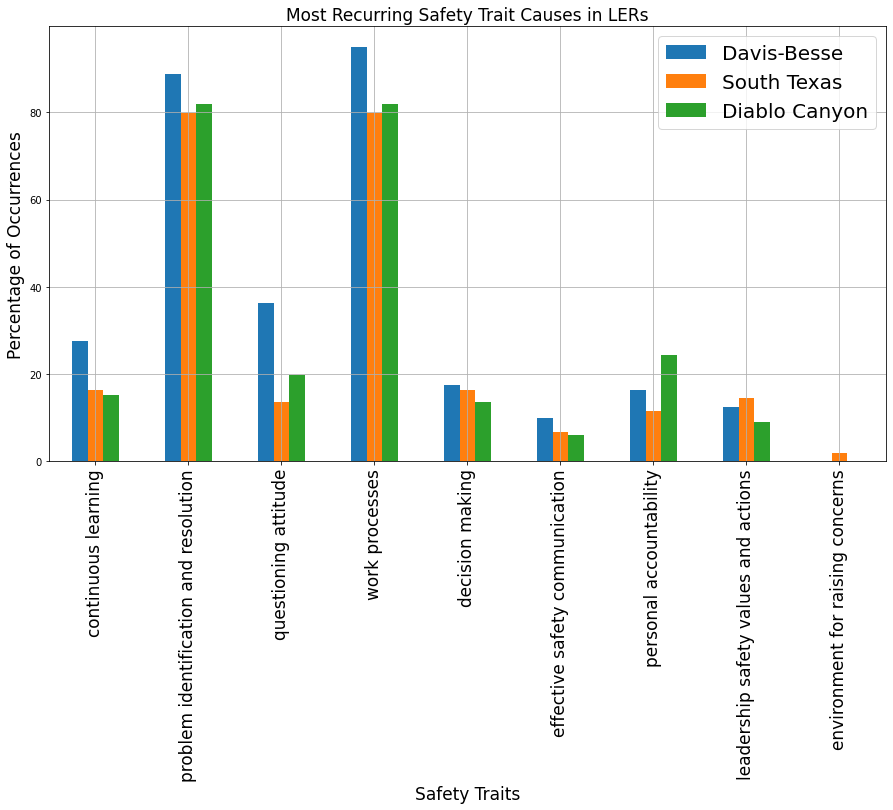

In [115]:
# Transpose the DataFrame
flipped_df = df_Counts.transpose()

# Plot a bar chart with percentages
fig, ax = plt.subplots(figsize=(15, 8))
flipped_df.plot(kind='bar', rot=90, grid=True, ax=ax)
plt.title('Most Recurring Safety Trait Causes in LERs',fontsize=17)
plt.xlabel('Safety Traits',fontsize=17)
plt.ylabel('Percentage of Occurrences',fontsize=17)
plt.xticks(fontsize = 17)
plt.legend(fontsize = 20)
plt.show()